# Connected Devices Study

This notebook investigates the number of connected devices from the data saved in the previous notebook ([05_Connected_Devices_Extraction](05_Connected_Devices_Extraction.ipynb))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import aux_balena as aux
from tqdm import tqdm_notebook
%matplotlib inline
from datetime import datetime, timedelta
import pickle

### Import data

In [4]:
# import dictionaries
conn_dev_1day = pickle.load( open('connected_devices_1day.pk','rb'))
print('1Day dict length:',len(conn_dev_1day))
conn_dev_28day = pickle.load( open('connected_devices_28days.pk','rb'))
print('28Days dict length:',len(conn_dev_28day))

1Day dict length: 1005
28Days dict length: 1005


In [5]:
# import device-user database
device_user_db = pd.read_csv('Device_user_database.csv')
device_user_db.head()

device_id  user_id
0          1        1
1          2        2
2          3        1
3          4        1
4          5        1

## Functions

The following function returns a segmented count based on fleet size starting from an array of device_id's.

Although the instructions reported as last category the range '100-999', I have implemented instead a range '>100' because some users had up to 10000 devices.

In [6]:
def device_array_to_segm_count(inp, device_user_db, bins=[0,2,9,99,1e6],labels=['1-2','3-9','10-99','>100']):
    # inp is an arry with active device id's
    # device_user_db is the database with device-user relations
    
    # dataframe with inp (active devices)
    inp_df = pd.DataFrame({'device_id': inp})
    # join tables
    inp_df = inp_df.join(device_user_db.set_index('device_id'), on='device_id', how='left')
    # 1) group by user_id
    dfgroup = inp_df.groupby('user_id')['device_id'].count().to_frame()
    dfgroup.columns=['device_count']
    # cut and create category
    dfgroup['category'] = pd.cut(dfgroup.device_count,bins=bins, labels=labels)
    # 2) group by category and sum counts
    dfcat = dfgroup.groupby('category')['device_count'].sum().to_frame()
    #
    return dfcat

The following function loops through a dictionary of connected devices by date and collects the segmented count in a dataframe.

In [7]:
def connected_dict_to_segmented_frame( conn_dict, device_user_db ):
    # processes a dictionary with device_id's per day into a dataframe with segmented counts per each day
    
    for k, (key, array) in enumerate(tqdm_notebook( conn_dict.items())):
        # get the count segmented by fleet size
        dfcat = device_array_to_segm_count(array,device_user_db)
        # transpose
        dfcat=dfcat.transpose()
        # attach timestamp
        dfcat.index = pd.DatetimeIndex( [datetime.strptime(key,'%Y-%m-%d')])
        if k==0: # first
            res = dfcat
        else: # following ones
            res = pd.concat((res,dfcat))

    # change the index title
    res.columns.name = 'Timestamp'
    #
    return res

### Run

#### 1day segmented count

In [8]:
segm_count_1day = connected_dict_to_segmented_frame( conn_dev_1day, device_user_db )
segm_count_1day.head()

Timestamp   1-2  3-9  10-99  >100
2015-05-31   56   45     40   131
2015-06-01   63   60     42   130
2015-06-02   64   61     39   125
2015-06-03   78   46     53   121
2015-06-04   69   46     55   119

Export to csv

In [15]:
segm_count_1day.to_csv('Segmented_count_1day.csv',index_label='Timestamp')

#### 28day segmented count

In [9]:
segm_count_28day = connected_dict_to_segmented_frame( conn_dev_28day, device_user_db )
segm_count_28day.head()

Timestamp   1-2  3-9  10-99  >100
2015-05-31    0    0      0     0
2015-06-01   56   45     40   131
2015-06-02   65   61     42   139
2015-06-03   74   78     44   152
2015-06-04   85   71     60   162

In [10]:
segm_count_28day.to_csv('Segmented_count_28day.csv',index_label='Timestamp')

## Analytics

In [11]:
segm_count_1day.columns.name = 'Fleet size'

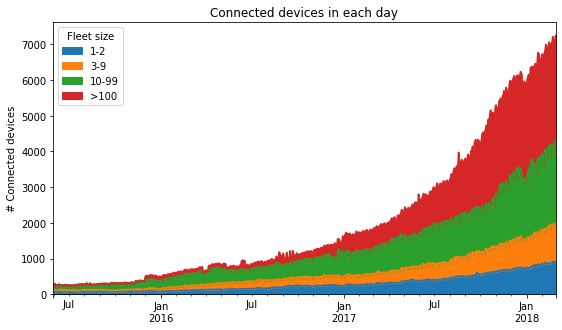

In [12]:
fig = plt.figure(figsize=(9,5));
ax = fig.add_subplot();
segm_count_1day.plot.area(ax = ax);
plt.ylabel('# Connected devices')
plt.title('Connected devices in each day');

In [13]:
segm_count_28day.columns.name = 'Fleet size'

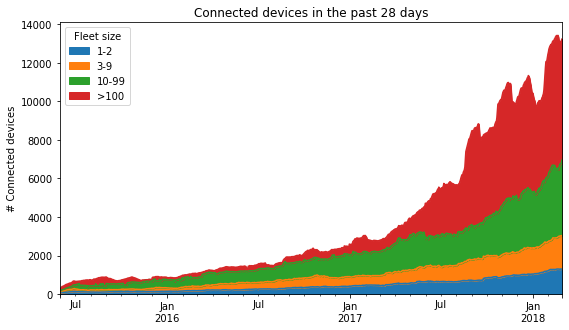

In [14]:
fig = plt.figure(figsize=(9,5));
ax = fig.add_subplot();
segm_count_28day.plot.area(ax = ax);
plt.ylabel('# Connected devices')
plt.title('Connected devices in the past 28 days');